# Create context-specific models using REDS RBC Omics data
## Setup
### Import packages

In [1]:
import re
from collections import defaultdict

import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mpl_venn
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    get_dirpath,
    read_cobra_model,
    show_versions,
    write_cobra_model,
)
from rbc_gem_utils.analysis.overlay import (
    ProteinDilution,
    add_relaxation_budget,
    load_overlay_model,
    update_slack_value,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL
from sklearn.metrics import r2_score

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()

Set parameter Username
Set parameter LicenseID to value 2664191

Package Information
-------------------
rbc-gem-utils 0.0.2

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                   1.8.0
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.2
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                              3.4.2
notebook                              7.4.2
openpyxl                              3.1.5
pandas                                2.2.3
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.3
scikit-learn                          1.6.1
scipy                                1.15.3
seaborn                              0.13.2

Build Tools Information
-----------

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,127
cache_directory,Path for the model cache,C:\Users\P7875\AppData\Local\opencobra\cobrapy\Cache
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


### Define organism, model, and dataset

In [3]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "REDS_RBCOmics"

### Set variables for columns keys and sample identification

In [4]:
sample_key = "SAMPLE ID"
donor_key = "PUBLIC DONOR ID"
time_key = "DAY"

# For sample IDs
timepoints = ["D10", "D23", "D42"]
phenotypes = ["G6PD_V68M"]
donor_re = re.compile(r'(?P<donor>(S\d\d\d))')
time_re = re.compile(r'D(?P<time>(\d\d))')
phenotype_re = re.compile(rf"(?P<phenotype>({'|'.join(phenotypes)})\S+)")

operations = "|".join([x.capitalize() for x in ["mean", "median"]]) 

operation_re = re.compile(
    r"(?P<op>" 
    + operations 
    + r")\_(?P<group>\w+)"
)
sample_id_re = re.compile(
    r"(?!" + operations + r")" 
    + donor_re.pattern
    + r"\_"
    + time_re.pattern
)

### Set computation options

In [ ]:
run_computations = False
verbose = True
objective_reactions = ["NaKt"]

### Set figure options

In [5]:
save_figures = True
transparent = False
imagetype = "svg"

## Load RBC-GEM model

In [6]:
valid_organisms = {"Human", "Mouse"}
if organism not in valid_organisms:
    raise ValueError(f"Organism must be one of the following: {valid_organisms}")

# Set paths
processed_data_dirpath = get_dirpath(use_temp="processed") / organism / dataset_name
overlay_dirpath = get_dirpath("analysis") / "OVERLAY" / organism
model_dirpath = overlay_dirpath / model_id

results_dirpath = get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name

fitting_dirpath = results_dirpath / "fitting"
sample_pcmodels_dirpath = results_dirpath / "sample_pcmodels"
# Ensure directories exist
results_dirpath.mkdir(exist_ok=True, parents=True)
fitting_dirpath.mkdir(exist_ok=True)
sample_pcmodels_dirpath.mkdir(exist_ok=True)

# Identify hemoglobin proteins
if organism == "Mouse":
    hemoglobin_proteins = {
        k.replace("-", "_"): v
        for k, v in {
            "Hba": "P01942",  # Hemoglobin subunit alpha
            "Hba-a1": "P01942",
            "Hbb-b1": "P02088",  # Hemoglobin subunit beta-1
            "Hbb-b2": "P02089",  # Hemoglobin subunit beta-2
            "Hbb-bh0": "P04443",  # Hemoglobin subunit beta-H0
            "Hbb-bh1": "P04444",  # Hemoglobin subunit beta-H1
            "Hbz": "P06467",  # Hemoglobin subunit zeta
            "Hba-x": "P06467",
            "Hbz1": "P06467",
            "Hbb-y": "P02104",  # Hemoglobin subunit epsilon-Y2
        }.items()
    }
else:
    hemoglobin_proteins = {
        "HBA": "P69905",  # Hemoglobin subunit alpha
        "HBB": "P68871",  # Hemoglobin subunit beta
        "HBD": "P02042",  # Hemoglobin subunit delta
        "HBE1": "P02100",  # Hemoglobin subunit beta
        "HBG1": "P69891",  # Hemoglobin subunit gamma-1
        "HBG2": "P69892",  # Hemoglobin subunit gamma-2
        "HBM": "Q6B0K9",  # Hemoglobin subunit mu
        "HBQ1": "P09105",  # Hemoglobin subunit theta-1
        "HBZ": "P02008",  # Hemoglobin subunit zeta
    }

# Load models
model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=model_dirpath / f"{model_id}_PC.xml")

pcmodel

Name,RBC_GEM_PC
Memory address,20984e93510
Number of metabolites,10410
Number of reactions,18799
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


## Load copy numbers and protein data

In [7]:
# Load protein copy numbers
df_copy_numbers = pd.read_csv(
    processed_data_dirpath / f"{dataset_name}_ProteinCopyNumbers.tsv", sep="\t", index_col=sample_key
)

# Load MCH for transforming data
df_MCH = pd.read_csv(
    processed_data_dirpath / f"{dataset_name}_MCH.tsv", sep="\t", index_col=sample_key
)
# Load intensity data as weighting matrix
df_weighting_mat = pd.read_csv(
    processed_data_dirpath / f"{dataset_name}_ProteinIntensities.tsv", sep="\t", index_col=sample_key
)

# Load protein data
df_protein_data = pd.read_csv(
    processed_data_dirpath / f"{dataset_name}_ProteinData.tsv",
    sep="\t",
    index_col="Entry",
)

all_ids = list(df_copy_numbers.index.unique())
operation_ids = [x for x in all_ids if operation_re.match(x)]
sample_ids = [x for x in all_ids if sample_id_re.match(x)]

print(f"Number of measured samples: {len(sample_ids)}")
print(f"Number of operation samples: {len(operation_ids)}")
print(f"Number of models to generate: {len(all_ids)}")

Number of measured samples: 1830
Number of operation samples: 1232
Number of models to generate: 3062


## Integrate proteomics with model
### Convert copy numbers to mg / gDW

In [8]:
df_uniprot_to_mw = df_protein_data["Mass"] / 1000  # g/mol --> # kg / mol
df_mg_prot_per_gDW = (
    df_copy_numbers[df_protein_data.index].mul(1 / df_MCH.squeeze(), axis=0)  # cell / pgDW
    * (1e12 / 1)  # pgDW / gDW
    * (1 / AVOGADRO_NUMBER)  # mol / protein copies
    * (df_uniprot_to_mw)  # kg / mol
    * (1e6 / 1)  # mg / kg
).copy()
df_mg_prot_per_gDW = df_mg_prot_per_gDW.loc[df_copy_numbers.index]
df_mg_prot_per_gDW

,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
S001_D10,0.083793,0.044933,0.012483,0.000734,0.176563,0.000000,0.006408,0.000000,0.231702,0.044519,...,0.003529,0.000000,0.032783,0.095664,0.000000,0.022264,0.016884,0.000000,0.027992,0.148679
S001_D23,0.061267,0.012738,0.000000,0.000000,0.158750,0.000000,0.020524,0.100649,0.231575,0.046045,...,0.002367,0.000000,0.019371,0.000000,0.000000,0.022821,0.107913,0.014679,0.025750,0.141962
S001_D42,0.091152,0.036613,0.045723,0.000000,0.163806,0.000000,0.019039,0.000000,0.219781,0.061550,...,0.005518,0.001095,0.019612,0.103183,0.005203,0.033628,0.014685,0.016423,0.020854,0.141946
S002_D10,0.000000,0.000000,0.000000,0.000000,0.164651,0.007409,0.015328,0.000000,0.000000,0.007605,...,0.007988,0.000000,0.032923,0.056093,0.000000,0.031285,0.000000,0.000000,0.070022,0.163131
S002_D23,0.036758,0.000000,0.279535,0.000000,0.295799,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006029,0.027521,0.027789,0.007937,0.000000,0.044366,0.000000,0.000000,0.073853,0.053572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mean_G6PD_V68M_1,0.078161,0.022342,0.030474,0.000971,0.133926,0.002429,0.016144,0.031742,0.053685,0.041623,...,0.004137,0.001047,0.025059,0.030413,0.001601,0.029582,0.012868,0.214130,0.032504,0.079043
Mean_G6PD_V68M_2,0.096633,0.005371,0.057715,0.000000,0.427016,0.007450,0.030289,0.028683,0.060271,0.079855,...,0.004872,0.001638,0.022426,0.045397,0.000486,0.030975,0.008122,0.269528,0.035153,0.095200
Median_G6PD_V68M_0,0.061499,0.000000,0.019807,0.000000,0.211823,0.000698,0.014004,0.000000,0.000000,0.049548,...,0.005260,0.000000,0.025391,0.023712,0.000000,0.030494,0.010260,0.000000,0.035995,0.095241


### Scale measurements for proteome budget
Note that this step will help ensure its theoretically possible for a perfect fit 

In [9]:
la_proteome_budget_value = 50
hemoglobin_budget_value = 950
total_budget_value = None

In [10]:
# Split into hemoglobin and low abundance proteomes
df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW.loc[
    :, df_mg_prot_per_gDW.columns.isin(hemoglobin_proteins.values())
]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW.loc[
    :, ~df_mg_prot_per_gDW.columns.isin(hemoglobin_proteins.values())
]

df_summary = {
    "Perfect total": 1000,
    "Current total": df_mg_prot_per_gDW.loc[sample_ids].sum(axis=1).mean().item(),
    "Hemoglobin total": df_mg_prot_per_gDW_hb.loc[sample_ids].sum(axis=1).mean().item(),
    "Low abundance total": df_mg_prot_per_gDW_la.loc[sample_ids]
    .sum(axis=1)
    .mean()
    .item(),
}
df_summary["Remaining/Excess"] = df_summary["Perfect total"] - (
    df_summary["Hemoglobin total"] + df_summary["Low abundance total"]
)

PBDL_proteome_budget = pcmodel.reactions.get_by_id("PBDL_proteome_budget")
PBDL_hemoglobin_budget = pcmodel.reactions.get_by_id("PBDL_hemoglobin_budget")
PBDL_total_budget = pcmodel.reactions.get_by_id("PBDL_total_budget")

if la_proteome_budget_value is None:
    la_proteome_budget_value = PBDL_proteome_budget.upper_bound
if hemoglobin_budget_value is None:
    hemoglobin_budget_value = PBDL_hemoglobin_budget.upper_bound
if total_budget_value is None:
    total_budget_value = PBDL_total_budget.upper_bound

assert total_budget_value >= (la_proteome_budget_value + hemoglobin_budget_value)

PBDL_proteome_budget.upper_bound = la_proteome_budget_value
PBDL_hemoglobin_budget.upper_bound = hemoglobin_budget_value
PBDL_total_budget.upper_bound = total_budget_value

# Scale values for low abundance proteome
budget_value = la_proteome_budget_value
df_mg_prot_per_gDW_la = (
    budget_value * (df_mg_prot_per_gDW_la.T / df_mg_prot_per_gDW_la.sum(axis=1)).T
)
df_summary["Low abundance scaled"] = budget_value

# Scale values for hemoglobin proteome
budget_value = hemoglobin_budget_value
df_mg_prot_per_gDW_hb = (
    budget_value * (df_mg_prot_per_gDW_hb.T / df_mg_prot_per_gDW_hb.sum(axis=1)).T
)
df_summary["Hemoglobin scaled"] = budget_value

budget_value = total_budget_value - sum(
    [la_proteome_budget_value, hemoglobin_budget_value]
)
df_summary["Remaining scaled"] = budget_value

# Combine dataframes back into one
df_mg_prot_per_gDW_normalized = pd.concat(
    (df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la), axis=1
)
df_summary = pd.DataFrame.from_dict(
    {
        " " * max(30 - len(k), 0) + k: [f"{v:.4f}", f"{v / 1000 * 100:.1f}%"]
        for k, v in df_summary.items()
    },
    orient="index",
    columns=["mg protein / gDW / cell", "Percentage"],
)
print(df_summary)
df_mg_prot_per_gDW_normalized.sum(axis=1)

                     mg protein / gDW / cell Percentage
       Perfect total               1000.0000     100.0%
       Current total               1000.0000     100.0%
    Hemoglobin total                429.4023      42.9%
 Low abundance total                570.5977      57.1%
    Remaining/Excess                  0.0000       0.0%
Low abundance scaled                 50.0000       5.0%
   Hemoglobin scaled                950.0000      95.0%
    Remaining scaled                  0.0000       0.0%


SAMPLE ID
S001_D10              1000.0
S001_D23              1000.0
S001_D42              1000.0
S002_D10              1000.0
S002_D23              1000.0
                       ...  
Mean_G6PD_V68M_1      1000.0
Mean_G6PD_V68M_2      1000.0
Median_G6PD_V68M_0    1000.0
Median_G6PD_V68M_1    1000.0
Median_G6PD_V68M_2    1000.0
Length: 3062, dtype: float64

### Convert mg / gDW to nmol / gDW

In [11]:
df_nmol_prot_per_gDW = (
    df_mg_prot_per_gDW_normalized  # mg / gDW
    * (1 / df_uniprot_to_mw)  # mol / kg --> mmol / g --> umol / mg
    * (1e3 / 1)  # nmol / umol
).loc[:, df_mg_prot_per_gDW_normalized.columns]
df_nmol_prot_per_gDW = df_nmol_prot_per_gDW.T
df_nmol_prot_per_gDW

SAMPLE ID,S001_D10,S001_D23,S001_D42,S002_D10,S002_D23,S002_D42,S003_D10,S003_D23,S003_D42,S004_D10,...,Mean_D42,Median_D10,Median_D23,Median_D42,Mean_G6PD_V68M_0,Mean_G6PD_V68M_1,Mean_G6PD_V68M_2,Median_G6PD_V68M_0,Median_G6PD_V68M_1,Median_G6PD_V68M_2
P02008,5711.701488,6195.993951,8202.371061,10030.992827,9267.072179,9577.944760,7761.886683,9585.442147,7386.126355,7139.463629,...,7271.938694,7646.808509,7445.502246,7629.421790,7221.635267,6863.573011,7372.242450,7571.774395,6994.208460,7713.013567
P02042,23598.528519,23922.365911,15256.582852,27625.580957,27930.313499,25892.111687,23732.280301,18498.546948,30364.640014,15743.006155,...,24239.815921,24321.870692,24337.876324,24113.867167,24310.057984,23768.601892,24879.851410,24239.767428,24118.974343,24494.073380
P02100,2.705134,3.509404,7.697601,4.510245,289.081171,6.809605,17.970784,4.306167,8.942239,4.057600,...,22.453482,6.385500,5.865061,6.073735,24.678340,11.739038,33.828837,6.107412,5.929283,6.948159
P09105,38.067281,36.529563,42.859252,60.526125,81.707715,52.171248,29.875331,41.622117,38.394597,34.410908,...,41.222354,41.475644,41.234135,41.633510,41.165918,52.758537,41.998024,41.443107,45.410994,44.328675
P68871,9503.146391,10031.605421,11963.335657,5453.197068,5092.491052,6879.143103,9390.955205,11351.030090,9217.858990,11122.192261,...,10293.546666,10239.843983,10193.572656,10338.537273,10262.795677,10244.466174,10492.765620,10246.483764,10022.420467,10593.014145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.038086,0.040313,0.054938,0.062468,0.090008,0.072397,0.045219,0.055560,0.068864,0.042550,...,0.054363,0.056316,0.055450,0.054769,0.054563,0.052571,0.056473,0.055444,0.055101,0.056894
Q9Y6I3,0.023621,0.155896,0.019620,0.000000,0.000000,0.000000,0.029578,0.000000,0.000000,0.016981,...,0.015160,0.018676,0.014226,0.013254,0.017857,0.018702,0.012110,0.015256,0.018518,0.011105
Q9Y6M4,0.000000,0.024880,0.025744,0.000000,0.000000,0.000000,0.000000,0.035888,0.000000,0.027049,...,0.153183,0.000000,0.000000,0.000000,0.129237,0.365129,0.471490,0.000000,0.018629,0.000000
Q9Y6M5,0.042697,0.040559,0.030378,0.124667,0.133595,0.114644,0.050889,0.081279,0.107624,0.036415,...,0.059013,0.058478,0.057806,0.058841,0.058251,0.051505,0.057144,0.058354,0.052026,0.053556


## Create DataFrame for protein dilution reactions

In [12]:
df_model_protein_dilutions = pd.concat(
    (
        pd.Series(
            {g.annotation.get("uniprot"): g.id for g in model.genes}, name="genes"
        ),
        pd.Series(
            {
                protdl.annotation.get("uniprot"): protdl.id
                for protdl in pcmodel.reactions.query(
                    lambda x: isinstance(x, ProteinDilution)
                )
            },
            name="PROTDL",
        ),
    ),
    axis=1,
)
df_model_protein_dilutions.index.name = "uniprot"
df_model_protein_dilutions = df_model_protein_dilutions[
    df_model_protein_dilutions["genes"].isin(model.genes.list_attr("id"))
].sort_values("PROTDL")
df_model_protein_dilutions

,genes,PROTDL
uniprot,,
Q9NPC4,A4GALT,PROTDL_protein_A4GALT_pc
P49588,AARS1,PROTDL_protein_AARS1_pc
Q9NRN7,AASDHPPT,PROTDL_protein_AASDHPPT_pc
O95477,ABCA1,PROTDL_protein_ABCA1_pc
Q8IZY2,ABCA7,PROTDL_protein_ABCA7_pc
...,...,...
P07947,YES1,PROTDL_protein_YES1_pc
Q5W0Z9,ZDHHC20,PROTDL_protein_ZDHHC20_pc
Q9UIJ5,ZDHHC2,PROTDL_protein_ZDHHC2_pc


## Organize samples (optional)
Use this for organizing samples if time-outs are an issue or multiple runs are necessary

In [13]:
df_samples = df_nmol_prot_per_gDW.copy()
df_samples

SAMPLE ID,S001_D10,S001_D23,S001_D42,S002_D10,S002_D23,S002_D42,S003_D10,S003_D23,S003_D42,S004_D10,...,Mean_D42,Median_D10,Median_D23,Median_D42,Mean_G6PD_V68M_0,Mean_G6PD_V68M_1,Mean_G6PD_V68M_2,Median_G6PD_V68M_0,Median_G6PD_V68M_1,Median_G6PD_V68M_2
P02008,5711.701488,6195.993951,8202.371061,10030.992827,9267.072179,9577.944760,7761.886683,9585.442147,7386.126355,7139.463629,...,7271.938694,7646.808509,7445.502246,7629.421790,7221.635267,6863.573011,7372.242450,7571.774395,6994.208460,7713.013567
P02042,23598.528519,23922.365911,15256.582852,27625.580957,27930.313499,25892.111687,23732.280301,18498.546948,30364.640014,15743.006155,...,24239.815921,24321.870692,24337.876324,24113.867167,24310.057984,23768.601892,24879.851410,24239.767428,24118.974343,24494.073380
P02100,2.705134,3.509404,7.697601,4.510245,289.081171,6.809605,17.970784,4.306167,8.942239,4.057600,...,22.453482,6.385500,5.865061,6.073735,24.678340,11.739038,33.828837,6.107412,5.929283,6.948159
P09105,38.067281,36.529563,42.859252,60.526125,81.707715,52.171248,29.875331,41.622117,38.394597,34.410908,...,41.222354,41.475644,41.234135,41.633510,41.165918,52.758537,41.998024,41.443107,45.410994,44.328675
P68871,9503.146391,10031.605421,11963.335657,5453.197068,5092.491052,6879.143103,9390.955205,11351.030090,9217.858990,11122.192261,...,10293.546666,10239.843983,10193.572656,10338.537273,10262.795677,10244.466174,10492.765620,10246.483764,10022.420467,10593.014145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.038086,0.040313,0.054938,0.062468,0.090008,0.072397,0.045219,0.055560,0.068864,0.042550,...,0.054363,0.056316,0.055450,0.054769,0.054563,0.052571,0.056473,0.055444,0.055101,0.056894
Q9Y6I3,0.023621,0.155896,0.019620,0.000000,0.000000,0.000000,0.029578,0.000000,0.000000,0.016981,...,0.015160,0.018676,0.014226,0.013254,0.017857,0.018702,0.012110,0.015256,0.018518,0.011105
Q9Y6M4,0.000000,0.024880,0.025744,0.000000,0.000000,0.000000,0.000000,0.035888,0.000000,0.027049,...,0.153183,0.000000,0.000000,0.000000,0.129237,0.365129,0.471490,0.000000,0.018629,0.000000
Q9Y6M5,0.042697,0.040559,0.030378,0.124667,0.133595,0.114644,0.050889,0.081279,0.107624,0.036415,...,0.059013,0.058478,0.057806,0.058841,0.058251,0.051505,0.057144,0.058354,0.052026,0.053556


### Map samples to model

In [14]:
merge_key = "uniprot"
df_samples.index.name = merge_key

df_model = (
    df_model_protein_dilutions[["PROTDL"]]
    .merge(df_samples, left_index=True, right_index=True, how="left")
    .set_index("PROTDL")
    .sort_index()
)
no_experimental_measurements = [
    protein_dilution
    for protein_dilution, has_measurement in df_model.isna().all(axis=1).items()
    if has_measurement
]
print(
    f"Model proteins mapped to measurements: {len(df_model) - len(no_experimental_measurements)}"
)
print(f"Model proteins without measurements: {len(no_experimental_measurements)}")
df_model.dropna()

Model proteins mapped to measurements: 524
Model proteins without measurements: 296


,S001_D10,S001_D23,S001_D42,S002_D10,S002_D23,S002_D42,S003_D10,S003_D23,S003_D42,S004_D10,...,Mean_D42,Median_D10,Median_D23,Median_D42,Mean_G6PD_V68M_0,Mean_G6PD_V68M_1,Mean_G6PD_V68M_2,Median_G6PD_V68M_0,Median_G6PD_V68M_1,Median_G6PD_V68M_2
PROTDL,,,,,,,,,,,,,,,,,,,,,
PROTDL_protein_AARS1_pc,0.016548,0.016056,0.022910,0.039456,0.030369,0.037975,0.019119,0.008683,0.005173,0.010755,...,0.022708,0.023134,0.022880,0.022608,0.023032,0.021052,0.026827,0.022774,0.020598,0.025102
PROTDL_protein_AASDHPPT_pc,0.105539,0.094642,0.106604,0.023180,0.000000,0.000000,0.000000,0.000000,0.000000,0.111859,...,0.008828,0.000000,0.000000,0.000000,0.011134,0.007399,0.008467,0.000000,0.000000,0.000000
PROTDL_protein_ABCB6_pc,0.157586,0.141928,0.132416,0.094033,0.095336,0.104518,0.176915,0.086452,0.065404,0.139074,...,0.139090,0.143677,0.144166,0.143949,0.138627,0.162306,0.135160,0.144054,0.162701,0.154520
PROTDL_protein_ABCC1_pc,0.014914,0.014828,0.027336,0.000000,0.000000,0.000000,0.013321,0.045371,0.000000,0.017636,...,0.023908,0.018266,0.020132,0.021016,0.023496,0.022639,0.021174,0.019584,0.020412,0.020761
PROTDL_protein_ABCC4_pc,0.042641,0.046250,0.037210,0.056579,0.054304,0.045073,0.051173,0.046281,0.069150,0.051205,...,0.053608,0.057098,0.055518,0.056115,0.053608,0.059936,0.063111,0.056001,0.062989,0.068651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PROTDL_protein_WDR77_pc,0.468144,0.489826,0.485841,0.494281,0.520838,0.477451,0.442753,0.389425,0.376230,0.528052,...,0.466041,0.490857,0.496631,0.491856,0.467379,0.463644,0.445078,0.493899,0.484723,0.470388
PROTDL_protein_WNK1_pc,0.047562,0.055109,0.052594,0.025514,0.037551,0.015743,0.047097,0.049747,0.019674,0.058304,...,0.039295,0.041904,0.042569,0.042177,0.039406,0.042382,0.035149,0.042150,0.043476,0.037276
PROTDL_protein_XPNPEP1_pc,0.110483,0.109043,0.108751,0.115400,0.152629,0.089800,0.117508,0.122700,0.117942,0.096528,...,0.122858,0.128782,0.127344,0.126234,0.124043,0.143309,0.142029,0.127239,0.152598,0.143033


#### Summarize mapping

In [15]:
dataset_proteins = set(df_samples.index)
model_proteins = set(df_model_protein_dilutions.index)

df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW_normalized.loc[
    [
        x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids
    ],  # Don't include operation IDs
    [
        x
        for x in df_mg_prot_per_gDW_normalized.columns
        if x in list(hemoglobin_proteins.values())
    ],
]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW_normalized.loc[
    [
        x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids
    ],  # Don't include operation IDs
    [
        x
        for x in df_mg_prot_per_gDW.columns
        if not x in list(hemoglobin_proteins.values())
    ],
]

df_mapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, ~df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_mapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, ~df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)

proteomes = {}
round_int = 6
for label, df in zip(
    ["hemoglobin", "low abundance"], [df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la]
):
    df_modeled = df.loc[:, df.columns.isin(model_proteins)].sum(axis=1)
    df_remaining = df.loc[:, ~df.columns.isin(model_proteins)].sum(axis=1)
    means = (df_modeled.mean(), df_remaining.mean())
    stdevs = (df_modeled.std(), df_remaining.std())
    proteomes[(label, "modeled")] = round(means[0], round_int)
    proteomes[(label, "remaining")] = round(means[1], round_int)
proteomes = pd.Series(proteomes, name="Mean value across samples")
proteomes.index = [f"Mean {k[0]} mass {k[1]}" for k in proteomes.index]
print(proteomes.head())
proteomes = proteomes[proteomes != 0]

Mean hemoglobin mass modeled         950.000000
Mean hemoglobin mass remaining         0.000000
Mean low abundance mass modeled       25.266957
Mean low abundance mass remaining     24.733043
Name: Mean value across samples, dtype: float64


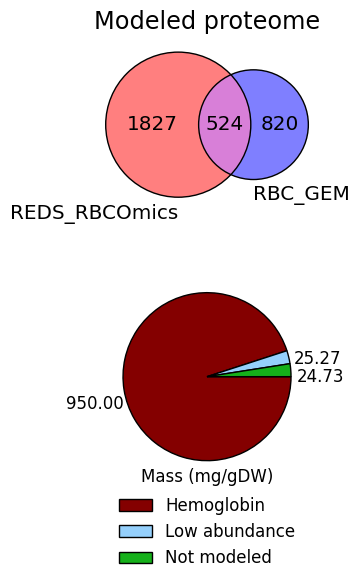

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))
subsets = (
    len(dataset_proteins),
    len(model_proteins),
    len(dataset_proteins.intersection(model_proteins)),
)


venn = mpl_venn.venn2(
    subsets=subsets,
    set_labels=(dataset_name, model.id),
    set_colors=("red", "blue"),
    alpha=0.5,
    ax=ax1,
)
circles = mpl_venn.venn2_circles(
    subsets=subsets, linestyle="-", color="black", ax=ax1, linewidth=1
)
for text in venn.set_labels:
    text.set_fontsize("x-large")
for text in venn.subset_labels:
    text.set_fontsize("x-large")
ax1.set_title("Modeled proteome", fontsize="xx-large")


label_color_map = {
    "Mean hemoglobin mass modeled": ("Hemoglobin", "xkcd:dark red"),
    "Mean low abundance mass modeled": ("Low abundance", "xkcd:light blue"),
    "Mean low abundance mass remaining": ("Not modeled", "xkcd:green"),
}
edgecolor = "black"
linewidth = 1
ax2.pie(
    x=proteomes.values,
    colors=[label_color_map[k][1] for k in proteomes.index],
    pctdistance=1.35,
    counterclock=False,
    autopct=lambda pct: f"{pct * 1000/100:.2f}\n",
    textprops=dict(fontsize="large", ha="center", va="top"),
    wedgeprops=dict(edgecolor=edgecolor, linewidth=linewidth),
)
handles = [
    mpl.patches.Patch(
        edgecolor=edgecolor,
        linewidth=linewidth,
        label=label_color_map[k][0],
        facecolor=label_color_map[k][1],
    )
    for k in proteomes.index
]
ax2.legend(
    handles=handles,
    ncols=1,
    bbox_to_anchor=(0.5, 0),
    loc="upper center",
    fontsize="large",
    frameon=False,
)
ax2.set_xlabel("Mass (mg/gDW)", fontsize="large", labelpad=-10)
if save_figures:
    fig.savefig(
        results_dirpath / f"ModeledProteome.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

## Create QP model for each sample

In [17]:
def solve_qp(pcmodel, df):
    x = []  # Variables
    c = []  # Data * Weights
    F = []  # Weights

    for protdl, (data_value, weight) in df.iterrows():
        protdl = pcmodel.reactions.get_by_id(protdl)
        x.append(protdl.flux_expression)
        c.append(weight * data_value)
        F.append(weight)

    x = sympy.Matrix(x)
    c = sympy.Matrix(c)
    F = sympy.DiagMatrix(sympy.Matrix(F))
    # # QP Objective must be in form of 0.5 * x.T * F * x - c.T * x
    objective = 0.5 * x.T * F * x - c.T * x
    pcmodel.objective = objective[0]
    pcmodel.objective_direction = "min"
    pcmodel.tolerance = 1e-9

    qp_sol = pcmodel.optimize()
    return qp_sol


def solve_qp_for_samples(
    pcmodel, df_samples, df_weights=None, log_zero_replacement=1e-6, verbose=False
):
    qp_solutions_dict = {}
    for sample_id, data_series in df_samples.items():
        # Get protein values
        data_series.name = "Data"
        if df_weights is None:
            data_weights = 1 / data_series.replace(0, 1)
            data_weights = data_weights / data_weights.mean()
        else:
            data_weights = df_weights.loc[:, sample_id]
        # Get protein weights
        data_weights.name = "Weights"

        # Map to model, currently model mapping DataFrame generated outside scope of function
        df_model_data_weights = (
            df_model_protein_dilutions[["PROTDL"]]
            .merge(data_series, left_index=True, right_index=True, how="left")
            .merge(data_weights, left_index=True, right_index=True, how="left")
            .set_index("PROTDL")
            .sort_index()
        )

        df = (
            df_model_data_weights.loc[:, [data_series.name, data_weights.name]]
            .dropna(axis=0, how="all")
            .astype(float)
        )

        with pcmodel:
            qp_sol = solve_qp(pcmodel, df)
        
        df_qp_sol = qp_sol.fluxes.loc[
            pcmodel.reactions.query(lambda x: isinstance(x, ProteinDilution)).list_attr(
                "id"
            )
        ]
        df_qp_sol = (
            pd.concat((df_model_data_weights, df_qp_sol), axis=1).dropna().sort_index()
        )
        # data_weights = df_qp_sol.loc[:, "Weights"]

        df_qp_sol = df_qp_sol.rename(
            {"Data": "Measured Proteome", "fluxes": "Best-Fitted Proteome"}, axis=1
        )
        df_qp_sol = df_qp_sol.loc[:, ["Measured Proteome", "Best-Fitted Proteome"]]

        df = df_qp_sol.copy()
        r2 = r2_score(df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average")
        
        df = df_qp_sol.apply(lambda x: [log_zero_replacement if np.isclose(y, 0, atol=1e-12) else y for y in x]).apply(np.log10)
        r2_log10_w_outliers = r2_score(df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average")

        df = df_qp_sol[~df_qp_sol.apply(lambda x: np.isclose(x, 0).any(), axis=1)].apply(np.log10)
        r2_log10_wo_outliers = r2_score(df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average")
        r2_values = (r2, r2_log10_w_outliers, r2_log10_wo_outliers)
        qp_solutions_dict[sample_id] = (df_qp_sol, qp_sol.objective_value, r2_values)
        if verbose:
            # Recall that the objective is designed to try to minimize fitting error via maximizing R2, so 1 is a possibility
            print("Sample '{}'\tR^2: {:.4f}\tR^2 log10 w/outliers: {:.4f}\tR^2 log10 wo/outliers: {:.4f}\tObjective: {:.5f}".format(sample_id, *r2_values, qp_sol.objective_value))
        # TODO catch bad fits

    return qp_solutions_dict

### Set weightings for QP problem

In [18]:
# Ensure data is provided as (Protein IDs x Sample IDs)
# Use original copy number values for weights
df_weights = df_weighting_mat.T.loc[df_protein_data.index, df_samples.columns]
df_weights = 1 / df_weights.infer_objects(copy=False).replace(0, 1)
df_weights /= df_weights.mean()
df_weights

SAMPLE ID,S001_D10,S001_D23,S001_D42,S002_D10,S002_D23,S002_D42,S003_D10,S003_D23,S003_D42,S004_D10,...,Mean_D42,Median_D10,Median_D23,Median_D42,Mean_G6PD_V68M_0,Mean_G6PD_V68M_1,Mean_G6PD_V68M_2,Median_G6PD_V68M_0,Median_G6PD_V68M_1,Median_G6PD_V68M_2
Entry,,,,,,,,,,,,,,,,,,,,,
A0A075B6I0,0.045838,0.055799,0.043846,3.247836,0.044752,0.029903,0.101152,0.090863,2.796661,0.137842,...,0.075376,0.046609,0.049536,0.046858,0.077423,0.063752,0.037466,0.047752,0.067587,0.032992
A0A075B6I9,0.085482,0.268390,0.109159,3.247836,2.886157,3.597611,4.815362,3.717770,2.796661,5.676844,...,0.809004,4.206262,4.290998,4.156260,0.759297,0.223032,0.674091,4.206246,4.930698,4.119326
A0A075B6J9,0.307696,5.060673,0.087411,3.247836,0.005885,3.597611,4.815362,3.717770,2.796661,5.676844,...,0.089845,0.133603,0.179484,0.136238,0.098394,0.163512,0.062729,0.148263,0.260652,0.419605
A0A075B6K4,5.230472,5.060673,5.395902,3.247836,2.886157,3.597611,4.815362,3.717770,2.796661,5.676844,...,36.950694,4.206262,4.290998,4.156260,33.321080,5.134315,5.380267,4.206246,4.930698,4.119326
A0A075B6K5,0.021754,0.021535,0.024399,0.012144,0.005561,0.005221,0.044768,0.013060,0.009201,0.015819,...,0.021496,0.013727,0.014424,0.013381,0.022074,0.037206,0.008478,0.013864,0.032307,0.008261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.172518,0.149802,0.118851,0.063915,0.037077,0.060280,0.134882,0.073497,0.039531,0.156467,...,0.173472,0.094965,0.098135,0.095972,0.174280,0.168443,0.116882,0.096303,0.109376,0.093850
Q9Y6I3,0.227488,0.031680,0.272153,3.247836,2.886157,3.597611,0.168640,3.717770,2.796661,0.320633,...,0.508721,0.234181,0.312818,0.324334,0.435507,0.387226,0.445732,0.286224,0.266149,0.393209
Q9Y6M4,5.230472,0.232898,0.243353,3.247836,2.886157,3.597611,4.815362,0.109176,2.796661,0.236170,...,0.059071,4.206262,4.290998,4.156260,0.070601,0.023270,0.013433,4.206246,0.310415,4.119326


### Fit data by solving QP

In [19]:
log_zero_replacement = 1e-9
fitting_data = {"measured": {}, "best_fit": {}, "r2_objective": {}}
if run_computations:
    qp_solutions_dict = solve_qp_for_samples(
        pcmodel,
        df_samples,
        df_weights=df_weights,
        log_zero_replacement=log_zero_replacement,
        verbose=True,
    )

    for sample_id, (
        df_qp_sol,
        objective_value,
        r2_values,
    ) in qp_solutions_dict.items():
        fitting_data["measured"][sample_id] = df_qp_sol["Measured Proteome"].to_dict()
        fitting_data["best_fit"][sample_id] = df_qp_sol[
            "Best-Fitted Proteome"
        ].to_dict()
        fitting_data["r2_objective"][sample_id] = {
            "Objective": objective_value,
            "R^2" : r2_values[0],
            "R^2 log10 w/ outliers": r2_values[1],
            "R^2 log10 w/o outliers": r2_values[2],
        }
    for key, data in fitting_data.items():
        data = pd.DataFrame.from_dict(data, orient="columns")
        data.to_csv(fitting_dirpath / f"proteome_{key}.tsv", sep="\t", index=True)
        fitting_data[key] = data
else:
    for key in fitting_data.keys():
        fitting_data[key] = pd.read_csv(
            fitting_dirpath / f"proteome_{key}.tsv", sep="\t", index_col=0
        )
    qp_solutions_dict = {}
    for sample_id in df_samples.columns:
        df_qp_sol = pd.concat(
            (
                fitting_data["measured"].loc[:, sample_id],
                fitting_data["best_fit"].loc[:, sample_id],
            ),
            axis=1,
        )
        df_qp_sol.columns = ["Measured Proteome", "Best-Fitted Proteome"]
        r2_values = (
            fitting_data["r2_objective"].loc[:, sample_id].values
        )
        objective_value, r2_values = r2_values[0], r2_values[1:]
        qp_solutions_dict[sample_id] = (df_qp_sol, objective_value, r2_values)
print(f"Number of QP solutions: {len(qp_solutions_dict)}")

Number of QP solutions: 3062


### Plot fitting 
#### For the mean and median samples of each time point and for each chosen phenotype

In [20]:
samples_to_plot = np.array([
    [x for x in operation_ids if time_re.search(x) and operation_re.search(x).group("op") == "Mean"],
    [x for x in operation_ids if time_re.search(x) and operation_re.search(x).group("op") == "Median"],
    [x for x in operation_ids if phenotype_re.search(x) and operation_re.search(x).group("op") == "Mean"],
    [x for x in operation_ids if phenotype_re.search(x) and operation_re.search(x).group("op") == "Median"],
]).T
samples_to_plot

array([['Mean_D10', 'Median_D10', 'Mean_G6PD_V68M_0',
        'Median_G6PD_V68M_0'],
       ['Mean_D23', 'Median_D23', 'Mean_G6PD_V68M_1',
        'Median_G6PD_V68M_1'],
       ['Mean_D42', 'Median_D42', 'Mean_G6PD_V68M_2',
        'Median_G6PD_V68M_2']], dtype='<U18')

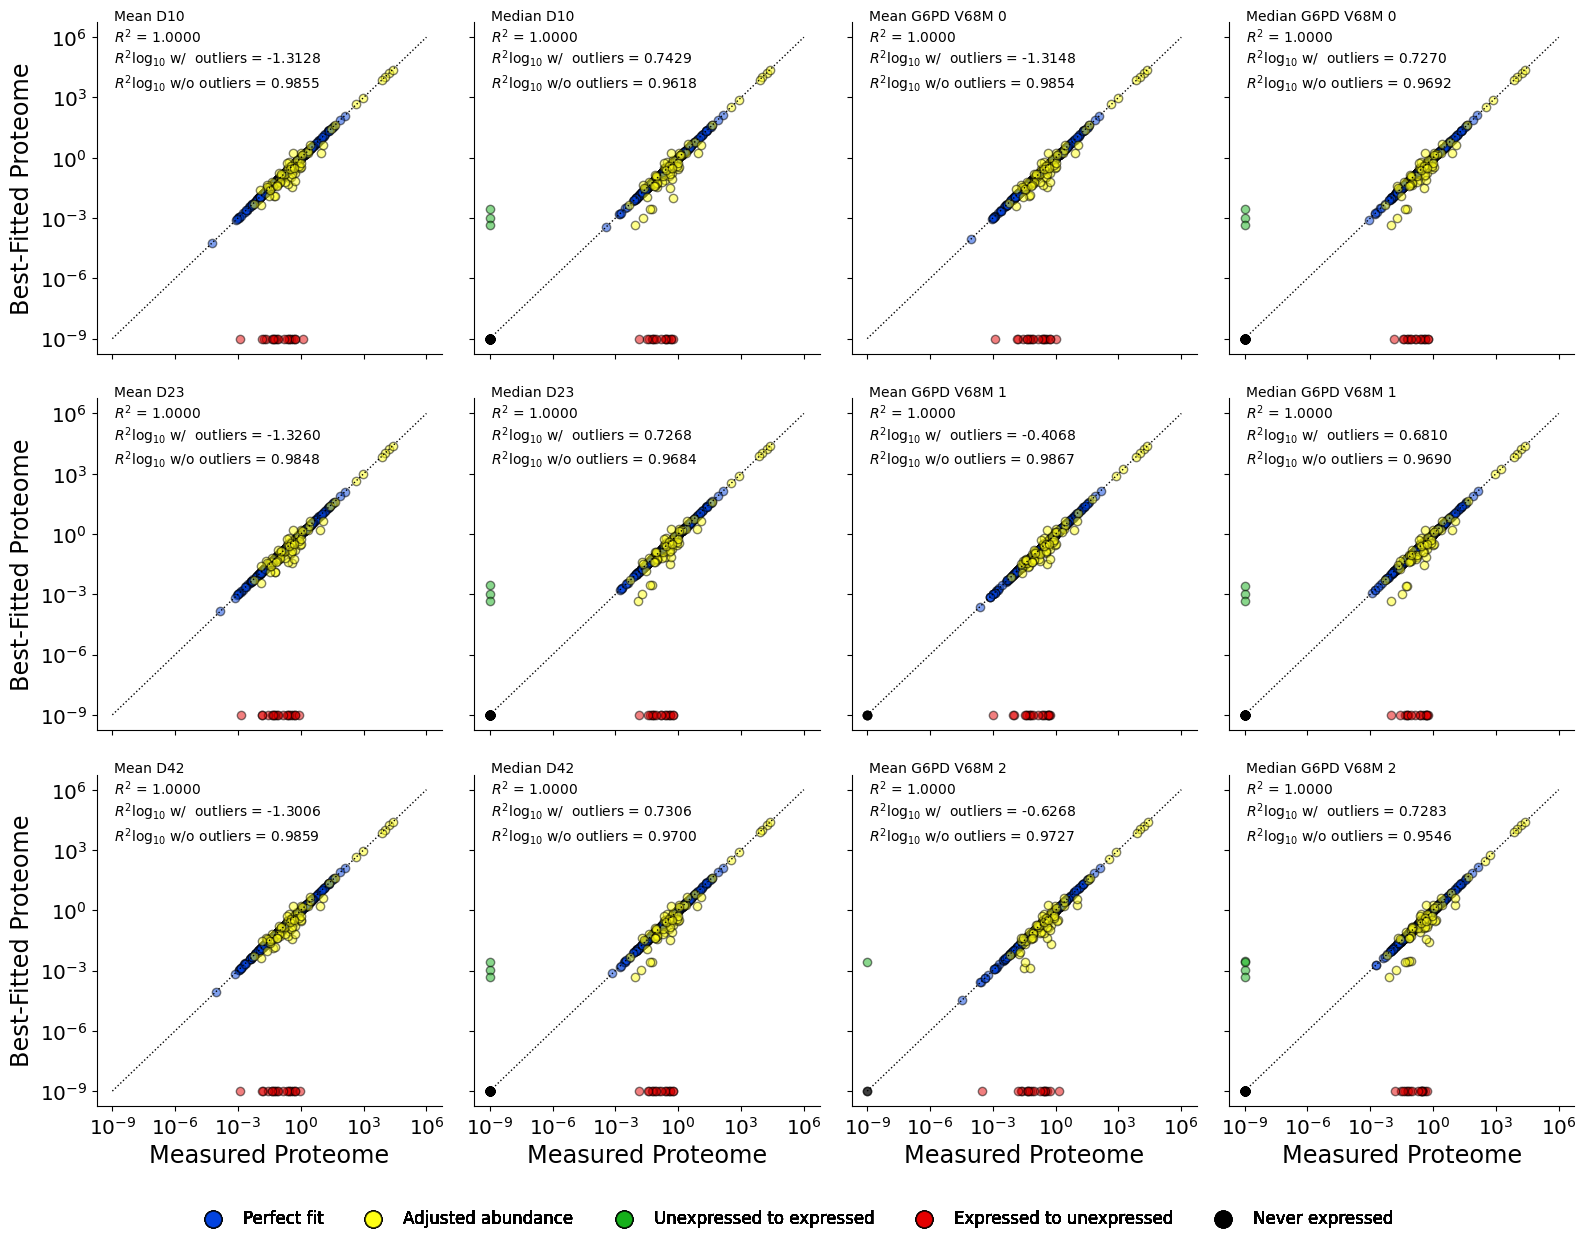

In [21]:
r2_text_loc = "upper left"
transform = False

length = 4
nrows, ncols = samples_to_plot.shape
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(length * ncols, length * nrows),
    sharex=True,
    sharey=True,
)
sns.despine(fig)
for idx, (sample_id, ax) in enumerate(zip(samples_to_plot.flatten(), axes.flatten())):
    df_qp_sol, objective_value, r2_values = qp_solutions_dict[sample_id]
    # Copy to prevent alterations to the original
    df_qp_sol = df_qp_sol.copy()
    xlabel, ylabel = df_qp_sol.columns

    ticks = 10 ** np.arange(*np.log10([log_zero_replacement, 1e8]), 3)
    if transform:
        ticks = np.log10(ticks)
        df_qp_sol.iloc[:, 0] = (
            df_qp_sol.iloc[:, 0]
            .apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x)
            .apply(np.log10)
        )
        df_qp_sol.iloc[:, 1] = (
            df_qp_sol.iloc[:, 1]
            .apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x)
            .apply(np.log10)
        )
    perfect_fit_line = ax.plot(
        [ticks[0], ticks[-1]],
        [ticks[0], ticks[-1]],
        linestyle=":",
        color="black",
        linewidth=1,
        alpha=1,
    )

    zero_val = 0 if not transform else np.log10(log_zero_replacement)

    df_zeros = df_qp_sol[
        (df_qp_sol.apply(lambda x: np.isclose(x, zero_val))).any(axis=1)
    ]
    df_perfect = df_qp_sol[
        np.isclose(
            abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
        )
    ]
    df_perfect = df_perfect[~df_perfect.index.isin(df_zeros.index)]

    df_altered = df_qp_sol[
        ~np.isclose(
            abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
        )
    ]
    df_altered = df_altered[~df_altered.index.isin(df_zeros.index)]
    df_always_zero = df_zeros[(df_zeros == zero_val).all(axis=1)]
    df_zeros = df_zeros[~df_zeros.index.isin(df_always_zero.index)]
    df_from_zeros = df_zeros[np.isclose(df_zeros["Measured Proteome"], zero_val)]
    df_to_zeros = df_zeros[np.isclose(df_zeros["Best-Fitted Proteome"], zero_val)]

    handles = [
        ax.scatter(
            data=df_perfect.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:blue",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_altered.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:yellow",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_from_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:green",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_to_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:red",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_always_zero.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:black",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
    ]
    labels = [
        f"Perfect fit",
        f"Adjusted abundance",
        f"Unexpressed to expressed",
        f"Expressed to unexpressed",
        f"Never expressed",
    ]

    sample_label = str(sample_id.replace(f"{pcmodel.id}_", "").replace("_", " "))
    if not transform:
        ax.set_xscale("log")
        ax.set_yscale("log")

    fontdict = {"size": "xx-large"}
    if idx >= len(samples_to_plot.flatten()) - ncols:
        ax.set_xlabel(xlabel, fontdict=fontdict)
    fig.legend(
        handles=handles,
        labels=labels,
        loc="upper center",
        ncols=len(labels),
        frameon=False,
        fontsize="large",
        markerscale=2,
        bbox_to_anchor=(0.5, -0.01),
    )
    if idx % ncols == 0:
        ax.set_ylabel(ylabel, fontdict=fontdict)

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.xaxis.set_tick_params(labelsize="x-large")
    ax.yaxis.set_tick_params(labelsize="x-large")

    r2_format = " = {:.4f}"
    if r2_text_loc == "lower right":
        ax.text(
            0.95,
            0.1,
            "\n".join(
                (
                    sample_label,
                    r"$R^{2}$" + r2_format.format(r2_values[0]),
                    r"$R^{2}\text{log}_{10}\text{ w/  outliers}$" + r2_format.format(r2_values[1]),
                    r"$R^{2}\text{log}_{10}\text{ w/o outliers}$" + r2_format.format(r2_values[2]),
                    
                )
            ),
            transform=ax.transAxes,
            color="black",
            fontsize="medium",
            ha="right",
        )
    elif r2_text_loc == "upper left":
        ax.text(
            0.05,
            0.8,
            "\n".join(
                (
                    sample_label,
                    r"$R^{2}$" + r2_format.format(r2_values[0]),
                    r"$R^{2}\text{log}_{10}\text{ w/  outliers}$" + r2_format.format(r2_values[1]),
                    r"$R^{2}\text{log}_{10}\text{ w/o outliers}$" + r2_format.format(r2_values[2]),
                    
                )
            ),
            transform=ax.transAxes,
            color="black",
            fontsize="medium",
            ha="left",
        )
    else:
        pass
fig.tight_layout()
if save_figures:
    fig.savefig(
        fitting_dirpath
        / f"QPfitting_{'' if not transform else 'log10_'}{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Determine best value for slack variable

In [22]:
verbose = True
objective_rxns = ["NaKt"]
slack_determination_models = samples_to_plot.flatten()

list_of_pcmodels = []
for sample_id in slack_determination_models:
    df_qp_sol, objective_value, r2_values = qp_solutions_dict[sample_id]
    # Create a copy of the model
    pcmodel_sample = pcmodel.copy()
    pcmodel_sample.id = f"{pcmodel.id}_{sample_id}"
    for protdl in pcmodel_sample.reactions.query(
        lambda x: isinstance(x, ProteinDilution)
    ):
        if protdl.id in df_qp_sol.index:
            prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
        else:
            prot_bound = 0
        protdl.bounds = (float(prot_bound), float(prot_bound))
    # Add the relaxation budget with slack = 0 first
    add_relaxation_budget(pcmodel_sample, 0, int(verbose))
    list_of_pcmodels += [pcmodel_sample]
    

Relaxation budget added to RBC_GEM_PC_Mean_D10, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Median_D10, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_G6PD_V68M_0, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Median_G6PD_V68M_0, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_D23, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Median_D23, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_G6PD_V68M_1, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Median_G6PD_V68M_1, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_D42, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxa

In [23]:
slack_min = 1e-5  # Slack %
slack_max = 1.5
if run_computations:
    solutions = {
        pcmodel_sample.id: {
            "model": [],
            "slack": [],
            "objective": [],
            "relaxation": [],
            "_".join(objective_rxns): [],
        }
        for pcmodel_sample in list_of_pcmodels
    }
    for slack_value in np.geomspace(slack_min, slack_max, 501):
        if int(verbose):
            print(f"Updating slack variable to {100 * slack_value:.6f}%.")
        for pcmodel_sample in list_of_pcmodels:
            update_slack_value(pcmodel_sample, slack_value, verbose=False)
            relaxation_demand = pcmodel_sample.reactions.get_by_id(
                f"PBDL_relaxation_budget"
            )
            pcmodel_sample.objective = (
                sum(
                    [
                        r.flux_expression
                        for r in pcmodel_sample.reactions.get_by_any(objective_rxns)
                    ]
                )
                - relaxation_demand.flux_expression
            )
            pcmodel_sample.objective_direction = "max"
            sol = pcmodel_sample.optimize()
            obj_value = sol.objective_value
            if not obj_value or np.isnan(obj_value):
                if int(verbose) > 1:
                    print(f"No solution for {100 * slack_value:.6f}%\n.")
                continue
            else:
                demand = relaxation_demand.flux
                budget = relaxation_demand.upper_bound
            solutions[pcmodel_sample.id]["model"].append(pcmodel_sample.id)
            solutions[pcmodel_sample.id]["slack"].append(slack_value)
            solutions[pcmodel_sample.id]["objective"].append(obj_value)
            solutions[pcmodel_sample.id]["_".join(objective_rxns)].append(
                obj_value + demand
            )
            solutions[pcmodel_sample.id]["relaxation"].append(demand / budget)
    solutions = {
        pcmodel_sample_id: pd.DataFrame.from_dict(sol)
        for pcmodel_sample_id, sol in solutions.items()
    }
    df_relaxation = pd.concat(list(solutions.values()), axis=0)
    df_relaxation.to_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.tsv",
        sep="\t",
        index=False,
    )
else:
    df_relaxation = pd.read_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.tsv", sep="\t"
    )
    solutions = {
        mid: df_relaxation[df_relaxation["model"] == mid].drop("model", axis=1)
        for mid in df_relaxation["model"].unique()
    }
df_relaxation

,model,slack,objective,relaxation,NaKt
0,RBC_GEM_PC_Mean_D10,0.019588,-0.842172,0.049354,0.100139
1,RBC_GEM_PC_Mean_D10,0.020061,-0.840894,0.048126,0.100139
2,RBC_GEM_PC_Mean_D10,0.020545,-0.839566,0.046926,0.100139
3,RBC_GEM_PC_Mean_D10,0.021040,-0.838184,0.045754,0.100139
4,RBC_GEM_PC_Mean_D10,0.021548,-0.836745,0.044607,0.100139
...,...,...,...,...,...
2192,RBC_GEM_PC_Median_G6PD_V68M_2,1.363586,0.027841,0.000059,0.106056
2193,RBC_GEM_PC_Median_G6PD_V68M_2,1.396480,0.027841,0.000057,0.106056
2194,RBC_GEM_PC_Median_G6PD_V68M_2,1.430167,0.027841,0.000056,0.106056
2195,RBC_GEM_PC_Median_G6PD_V68M_2,1.464668,0.027841,0.000055,0.106056


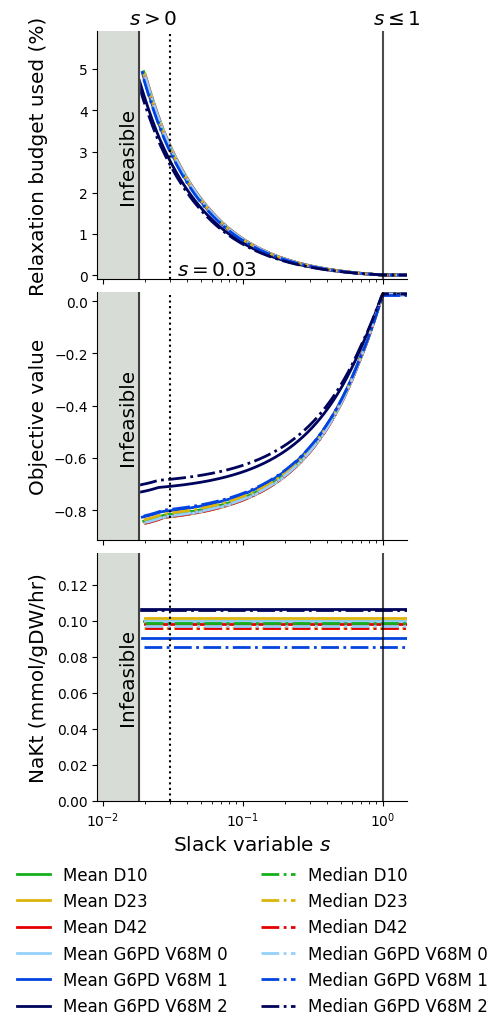

In [24]:
chosen_slack_var = 0.03
colors = {
    "D10": "xkcd:green",
    "D23": "xkcd:gold",
    "D42": "xkcd:red",
    "G6PD_V68M_0": "xkcd:light blue",
    "G6PD_V68M_1": "xkcd:blue",
    "G6PD_V68M_2": "xkcd:dark blue",
}
linestyles = {
    "Mean": "-",
    "Median": "-.",
}
use_percents = True

fig, axes = plt.subplots(
    3, 1, figsize=(4, 10), sharex=True, gridspec_kw=dict(hspace=0.05)
)
axes = axes.flatten()
sns.despine(fig)
for pcmodel_sample in list(sorted(list(solutions))):
    op, group = pcmodel_sample.replace(f"{pcmodel.id}_", "").split("_", maxsplit=1)
    color = colors.get(group, "xkcd:black")
    linestyle = linestyles.get(op, ":")
    s_values = solutions[str(pcmodel_sample)]["slack"].values
    r_values = solutions[str(pcmodel_sample)]["relaxation"].values * (
        100 if use_percents else 1
    )
    o_values = solutions[str(pcmodel_sample)]["objective"].values
    rxn_values = solutions[str(pcmodel_sample)]["_".join(objective_rxns)].values

    zorder = 1
    lw = 2
    axes[0].plot(
        s_values,
        r_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[1].plot(
        s_values,
        o_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[2].plot(
        s_values,
        rxn_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )

    # index = list(s_values).index(s_values[s_values >= chosen_slack_var][0])
    # spt = s_values[index]
    # rpt = r_values[index]
    # opt = o_values[index]
    # rxnpt = rxn_values[index]
    # c = "black"
    # ls = ""
    # marker = "o"
    # markersize = 8
    # axes[0].plot(spt, rpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[1].plot(spt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[2].plot(spt, rxnpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # ax3d.plot(spt, rpt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # print(f"Elbow point for {pcmodel_sample}: ({spt:.5f}, {rpt:.5f}, {opt:.5f})")
fontdict = {"size": "x-large"}
axes[-1].set_xlabel(r"Slack variable $s$", fontdict=fontdict)

zorder = 2
alpha = 0.7
limit_pad_sclar = 1.3
smin = s_values[0]

for i, ax in enumerate(axes):
    if i == 0:
        ymin, ymax = (
            -0.001 * (100 if use_percents else 1),
            max(r_values) * limit_pad_sclar,
        )
    elif i == 1:
        ymin, ymax = (
            min(0, min(o_values)) * limit_pad_sclar,
            max(o_values) * limit_pad_sclar,
        )
    elif i == 2:
        ymin, ymax = (0, max(rxn_values) * limit_pad_sclar)
    else:
        pass
    ax.vlines(chosen_slack_var, ymin=ymin, ymax=ymax, color="black", linestyle=":")
    ax.vlines(
        smin,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    ax.vlines(
        1,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    ax.set_xlim(smin / 2, slack_max)
    ax.set_ylim(ymin, ymax)
    ax.set_xscale("log")
    if i == 0:
        ax.annotate(
            rf"$s > 0$",
            xy=(smin, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s \leq 1$",
            xy=(1, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s = {chosen_slack_var}$",
            xy=(chosen_slack_var, 0),
            xycoords="data",
            xytext=(5, 0),
            textcoords="offset points",
            ha="left",
            fontsize=fontdict["size"],
        )
    ax.fill_between((smin / 2, smin), ymin, ymax, color="xkcd:light grey")
    ax.annotate(
        "Infeasible",
        xy=(smin, (ymax + ymin) / 2),
        xycoords="data",
        rotation=90,
        xytext=(-2, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        fontsize=fontdict["size"],
    )


handles, labels = axes[2].get_legend_handles_labels()
labels = [label.replace(f"{pcmodel.id}_", "").replace("_", " ") for label in labels]
axes[2].legend(
    handles=handles,
    labels=labels,
    ncols=2,
    frameon=False,
    loc="upper center",
    fontsize="large",
    bbox_to_anchor=(0.5, -0.2),
)


axes[0].set_ylabel("Relaxation budget used (%)", fontdict=fontdict)
axes[1].set_ylabel("Objective value", fontdict=fontdict)
axes[2].set_ylabel("NaKt (mmol/gDW/hr)", fontdict=fontdict)

fig.align_labels()
if save_figures:
    fig.savefig(
        fitting_dirpath / f"SlackPercentDetermination_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Formulate models from QP solutions

In [26]:
overwrite = False
# SBML/XML loads faster, but will take up to 4x more space uncompressed as compared to JSON
ftypes = {
    "xml"
    # "json",
}

slack_value = chosen_slack_var  # Slack %
ftypes = set([ftypes]) if isinstance(ftypes, str) else set(ftypes)
for sample_id, (df_qp_sol, objective_value, r2_values) in qp_solutions_dict.items():
    # Create a copy of the model
    sample_id = f"{pcmodel.id}_{sample_id}"
    filenames = [sample_pcmodels_dirpath / f"{sample_id}.{ftype}" for ftype in ftypes]
    if all([filename.exists() for filename in filenames]) and not overwrite:
        print(f"Model already created for {sample_id}")
        continue
    pcmodel_sample = pcmodel.copy()
    pcmodel_sample.id = sample_id
    for protdl in pcmodel_sample.reactions.query(
        lambda x: isinstance(x, ProteinDilution)
    ):
        if protdl.id in df_qp_sol.index:
            prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
        else:
            prot_bound = 0
        protdl.bounds = (float(prot_bound), float(prot_bound))
    # Add the relaxation budget
    add_relaxation_budget(pcmodel_sample, slack_value, verbose)
    # # Store model for later use
    # list_of_relaxed_models += [pcmodel_sample]
    for filename in filenames:
        # Might as well overwrite all files, especially if model needed to be regenerated anyways
        write_cobra_model(
            pcmodel_sample,
            filename=filename,
        )

Relaxation budget added to RBC_GEM_PC_S001_D10, extra 29.2788 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget added to RBC_GEM_PC_S001_D23, extra 29.2864 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget added to RBC_GEM_PC_S001_D42, extra 29.2838 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget added to RBC_GEM_PC_S002_D10, extra 29.2181 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget added to RBC_GEM_PC_S002_D23, extra 29.2708 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget added to RBC_GEM_PC_S002_D42, extra 29.2035 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget added to RBC_GEM_PC_S003_D10, extra 29.3182 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget added to RBC_GEM_PC_S003_D23, extra 29.2310 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget added to RBC_GEM_PC_S003_D42, extra 29.2062 mg/gDW (28.5000 mg HB/gDW) from 3.0000% slack
Relaxation budget added to R